In [1]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import src.helpers.model_helpers as mh
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform, uniform
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay
)

In [2]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [3]:
# We need to log transform and scale our numeric features before training
transform_features = ["income", "property_value", "loan_amount", "combined_loan_to_value_ratio"]

log_scale_pipe = Pipeline([
    ("log1p",  FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("logscale", log_scale_pipe, transform_features),
    ],
    remainder="passthrough", # Don't modify columns not in transform_features
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [4]:
# Create base classifier
base_log_reg = LogisticRegression(
    solver="saga", # Helps with larger datasets and elasticnet
    penalty="elasticnet",
    max_iter=5000,
    tol=1e-3, # Loosening convergence criteria slightly to save compute/time
    n_jobs=-1, # No limit on parallel threads
    random_state=42
)

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf",  base_log_reg)
])

# Specify how to randomly sample hyperparameters
param_grid = {
    "clf__C": loguniform(1e-3, 1e2),
    "clf__l1_ratio": uniform(0.0, 1.0),
    "clf__class_weight": [None, "balanced"]
}

# Able to shuffle data for splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=1, # Lowered the iterations (and k-fold splits) for functional testing before longer runs
    scoring="f1",
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

,estimator,Pipeline(step... tol=0.001))])
,param_distributions,"{'clf__C': <scipy.stats....t 0x129b3a510>, 'clf__class_weight': [None, 'balanced'], 'clf__l1_ratio': <scipy.stats....t 0x129baad50>}"
,n_iter,1
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [5]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'clf__C': np.float64(0.0745934328572655), 'clf__class_weight': None, 'clf__l1_ratio': np.float64(0.1834347898661638)}
Best CV F1: 0.45409009561746544


In [6]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "log_reg_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Test Performance:


,Score
F1,0.470880
Accuracy,0.806816
Precision,0.683453
Recall,0.359168
ROC AUC,0.799489
PR AUC,0.589198


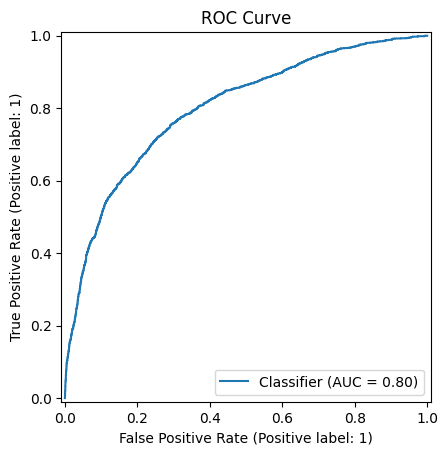

In [11]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "log_reg_roc")

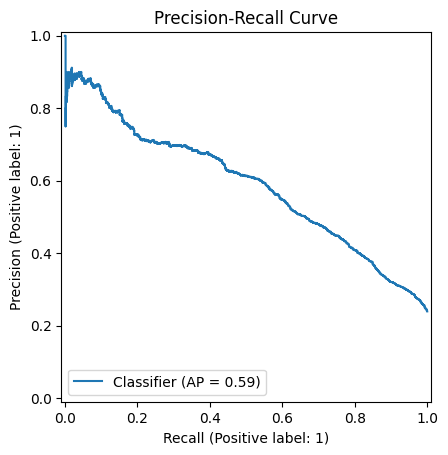

In [12]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "log_reg_pr")

In [10]:
# Persist fitted model
mh.persist_model(search, "log_reg_model")